In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sys import getsizeof
import numpy as np
import random
import math
from os.path import isfile
from sklearn.externals.six import StringIO
import pydotplus
import datetime
import igraph as ig
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import networkx as nx
from scipy.stats import binned_statistic
from collections import *
import cPickle as pickle
import objgraph
%load_ext memory_profiler
%load_ext line_profiler
import pandas as pd
import chardet
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC, SVR
from scipy.sparse import dok_matrix
import MySQLdb as sql
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from operator import itemgetter
from sklearn.grid_search import GridSearchCV
db = sql.connect('localhost', 'root', 'root', 'enys')
court = 'cjeu'

In [2]:
%run load_data.py

In [3]:
GRAPH = 'cjeu'
def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])
    
def calc_bag_of_words(court, metric='cosine'):
    """
    Perform bag-of-words vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_bow.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_bow.pkl'.format(court), 'rb'))
    else:
        count_vec = CountVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = count_vec.fit_transform(data[1])
        with open('pickles/{}_bow.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_bag_of_words(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_bag_of_words(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def calc_tf_idf(court, metric='cosine'):
    """
    Perform tf-idf vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_tfidf.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_tfidf.pkl'.format(court), 'rb'))
    else:
        tf_idf_vec = TfidfVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = tf_idf_vec.fit_transform(data[1])
        with open('pickles/{}_tfidf.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_tf_idf(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_tf_idf(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results
    
def successors_scoped(node, head, G):
    """
    Return the successors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return successors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G[node] if G.node[n]['date'] <= max_time]

def predecessors_scoped(node, head, G):
    """
    Return the predecessors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return predecessors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G.pred[node] if G.node[n]['date'] <= max_time]

def scoped_neighborhood(node, head_node, G):
    """
    Return the neighborhood of a node at a given timestamp
    
    arguments:
    node -- node to find the neighborhood for
    head_node -- node containing the timestamp to filter the nodes by
    G -- directed graph containing the node
    """
    max_date = G.node[head_node]['date']
    pre = predecessors_scoped(node, head_node, G)
    suc = successors_scoped(node, head_node, G)
    return list(set(pre).union(set(suc)))    
    
def scoped_out_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_in_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G.pred[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamop
    """
    return len(scoped_neighborhood(node, head_node, G))

def get_common_neighbors(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.intersection(v)

def get_neighbor_union(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.union(v)

def get_common_referrers(x,y,G):
    common_referrers_source = {n for m in successors_scoped(x, x, G) for n in predecessors_scoped(m, x, G)} - {x}
    referrers_to_target = set(predecessors_scoped(y,x,G))
    return common_referrers_source.intersection(referrers_to_target)

    
def common_referrers(validation_set, G, weighting_scheme=None):
    """
    For a given node pair x and y, return the number of nodes that both refer to a node that x also refers and refers to y
    or f(y) intersection g(f(x)) where f returns the predeccessors of a node and g returns the successors
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
 
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        cn = get_common_referrers(x,y,G)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, G) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def common_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

class WeightingScheme():
    
    def is_global(self):
        return self.weight_type == "global"
    def is_local(self):
        return self.weight_type == "local"
        

class Jaccard(WeightingScheme):
    
    def __init__(self):
        self.weight_type = "global"
    
    def score(self,x,y,G):
        """
        Perform jaccard scoring on a list of edges

        arguments:
        validation_set -- list of edges to score
        G -- digraph containing the nodes in the edges of the validation set

        returns:
        list of edges with score as an attribute
        """
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        try:
            s = 1.0*len(u & v)/len(u | v)
        except:
            s = 0.0
        return s
    
class AdamicAdar(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the AdamicAdar coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/math.log(scoped_degree(z, x, G))
        else:
            return 0.0

        
class ResourceAllocation(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/scoped_degree(z, x, G)
        else:
            return 0.0


        
class LeichtHolmeNewman(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'global'
        
    def score(self, x, y, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg > 0 and y_deg > 0:
            return 1.0/x_deg*y_deg
        else:
            return 0.0

class HubDepressed(WeightingScheme):
    def __init__(self):
        self.weight_type = 'local'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/min(x_deg, y_deg)
        else:
            return 0.0
    
class HubPromoted(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 or y_deg != 0:
            return 1.0/max(x_deg, y_deg)
        else:
            return 0.0

class Salton(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'


    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/math.sqrt(x_deg*y_deg)
        else:
            return 0.0

def hub_depressed(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 and scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/min(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def hub_promoted(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 or scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/max(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def salton(validation_set, G):
    """
    Find the salton similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/math.sqrt(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def leicht_holme_newman(validation_set, G):
    """
    Perform LHN1 scoring on a single edge
    
    arguments:
    non_edge -- edge tuple specified by node endpoints
    G -- graph containing the nodes in the edge
    
    return:
    edges with the score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = 1*sum([1.0/math.log(scoped_degree(node, x, G)) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/scoped_degree(node, x, G) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results


def preferential_attachment(validation_set, G):
    """
    Perform preferential attachment scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """

    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = scoped_out_degree(x,x,G)*scoped_in_degree(y,x,G)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_closeness(validation_set, G, census=None, weighting_scheme=None):
    
    results = []
    if census == None:
        census = triadic_distribution(G)
    for non_edge in validation_set:
        
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        cn = u.intersection(v)
        t_score = []
        for z in cn:
            triad = get_triad(x,z,y,G)
            if census[triad] == 0:
                continue
            try:
                F2 = census[triad+30]
            except KeyError:
                F2 = 0.0
            try:
                F1 = census[triad+10]
            except KeyError:
                F1 = 0.0
            
            # Add in any weighting schemes that work on the individual nodes in the common neighborhood
            if weighting_scheme and weighting_scheme.is_local():
                score = weighting_scheme.score(z, x, GCC)*(1.0*F1 + F2)/census[triad]
            else:
                score = (1.0*F1 + F2)/census[triad]
            
            t_score.append(score)
        s = sum(t_score)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x, y, G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def triadic_distribution(G):
    """
    Return the distribution of closed triad configurations for a graph
    The distribution is labelled as in the paper by Schall
    http://link.springer.com.proxy.findit.dtu.dk/article/10.1007/s13278-014-0157-9
    
    arguments:
    G -- directed graph
    
    returns:
    Dict of labels with counts
    """
    
    # Integer labels as presented in the paper
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30) + range (31, 40)
    census = {name: 0 for name in TRIAD_NAMES}
    for u in G.nodes_iter():
        u_neighbors = list(set(G.successors(u)) | set(G.predecessors(u)))
        for z in u_neighbors:
            z_neighbors = list((set(G.successors(z)) | set(G.predecessors(z))) - {u} )
            for v in z_neighbors:
                name = get_triad(u,z,v, G)
                census[name] += 1
    return census


def get_triad(u,z,v,G):
    """
    Return the triad created by the nodes u,v and z
    This implementation is quite probably awful.
    
    parameters:
    
    u -- starting node
    z -- connecting node
    v -- ending node
    G -- DiGraph containing the nodes
    
    returns:
    Dict containing closed triad counts
    """
    
    u_out = G[u]
    v_out = G[v]
    z_out = G[z]
    id = 0
    
    if v in u_out and u in v_out:
        id = 30
    elif u in v_out:
        id = 20
    elif v in u_out:
        id = 10
    
    if u in z_out and z not in u_out:
        id += 7
        if v in z_out and z not in v_out:
            return id + 2
        elif z in v_out and v not in z_out:
            return id + 1
        elif z in v_out and v in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in v_out and v not in z_out:
        id += 5
        if z in u_out and u not in z_out:
            return id + 1
        elif z in u_out and u in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u not in z_out:
        id += 3
        if v in z_out and z not in v_out:
            return id + 1
        if v in z_out and z in v_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u in z_out:
        if v in z_out and z not in v_out:
            return id + 2
        elif v in z_out and z in v_out:
            return id + 1
    
    raise Exception("No triad found")
        

def get_closed_triads(x, y, G):
    """
    Return the closed triads generated by adding a link from x to y.
    Triads are classified according to the triadic_census algorithm of NetworkX based on 
    http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
    """
    
    # Taken directly from nx.triadic_census source
    TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
                   '030T', '030C', '201', '120D', '120U', '120C', '210', '300')
    census = {name: 0 for name in TRIAD_NAMES}
    
    x_in = set(G.predecessors(x))
    y_in = set(G.predecessors(y))
    x_out = set(G.successors(x))
    y_out = set(G.successors(y))
    
    for node in x_in | y_in | x_out | y_out:
        # y refers to a node that refers to x
        if node in x_in and node in y_out:
            census['030C'] += 1
        # y is being referred to by a node that refers to x
        if node in x_in and node in y_in:
            census['030T'] += 1
        # x refers to a node that refers to y
        if node in x_out and node in y_in:
            census['030T'] += 1
        # x refers to a node that y refers to
        if node in x_out and node in y_out:
            census['030T'] += 1

def time_difference(candidate_edges, G):
    """
    Return the time difference for a set of edges
    """

    results = []
    
    results = [(x,y, {'score': int((G.node[x]['date'] - G.node[y]['date']).days)}) for x,y,_ in candidate_edges]
    return results

def shortest_dag_path(candidate_edges, G):
    results = []
    longest_possible_path = len(G.nodes())
    H = nx.Graph(G)
    for x,y,_ in candidate_edges:
        connected = y in G[x].keys()
        if connected:
            H.remove_edge(x,y)
        try:
            results.append((x,y,{'score': nx.shortest_path_length(H,x,y)}))
        except:
            results.append((x,y, {'score': longest_possible_path}))
        if connected:
            H.add_edge(x,y)
    return results
        
class CommonNeighbors():
    """
    An experiment that scores a list of edges based on the number of common neighbors between the source and the target node
    """
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
        
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common neighbors index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        false_validation_edges = [(source, target) for source in source_nodes
                   for neighbor in G[source].keys()
                   for target in set(scoped_neighborhood(neighbor, source, G)) - {source} if target not in G[source].keys()]
        
        false_validation_edges = list(set(false_validation_edges))
        for i in range(len(false_validation_edges)):
            edge = false_validation_edges[i]
            # Add date information to the non-edge
            false_validation_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return false_validation_edges
        
    def score_edges(self, edges, G):
        return common_neighbors(edges, G, self.weighting_scheme)
    
class TriadicCloseness(CommonNeighbors):
    
    def __init__(self, cache_distribution=False, weighting_scheme=None):
        self.cache_distribution = cache_distribution
        self.census = None
        self.weighting_scheme=weighting_scheme
    
    def score_edges(self, edges, G):
        
        if self.cache_distribution == True and self.census == None:
            self.census = triadic_distribution(G)
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
        else:
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
    
class CommonReferrers():
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
    
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common referrers index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        non_edges = []
        for source in source_nodes:
            neighbors = G[source].keys()
            corefs = set()
            for neighbor in neighbors:
                corefs = corefs | {c for c in predecessors_scoped(neighbor, source, G)}
            [non_edges.append((source, referee)) for coref in (corefs - {source}) 
                                                 for referee in set(successors_scoped(coref, source, G)) - set(neighbors)]
            
        for i in range(len(non_edges)):
            edge = non_edges[i]
            # Add date information to the non-edge
            non_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return non_edges
    
    def score_edges(self, edges, G):
        return common_referrers(edges, G, self.weighting_scheme)
            
                
def valid_random_non_edges(graph, n):
    """
    Returns randomized, non-existent links between nodes in the graph that are guaranteed to observe causality.

    Parameters
    ----------
    graph : NetworkX graph.
        Graph to find non-existent edges.
    n : integer
        Number of non-existent edges to find

    Returns
    -------
    non_edges : list
        List of n edges that are not in the graph.
    """
    result_pairs = {}
    # Sort edges according to age
    sorted_edges =[node for node, data in sorted(graph.nodes(data=True), key=lambda x: x[1]['date'], reverse=True)]
    node_set = set(graph.nodes())
    candidates = list(np.random.choice(sorted_edges, n, replace=True))
    i = 0
    while i < len(candidates):
        u = candidates[i]
        if not u in result_pairs.keys():
            result_pairs[u] = []
            
        # Make sure the potential neighbors respect causality with a resolution equal to the timestamp
        cand_index = sorted_edges.index(u)
        potential_neighbors = set(sorted_edges[cand_index:])
        if graph.is_directed():
            neighbors = set(graph.successors(u)).union(set(graph.predecessors(u)))
        else:
            neighbors = set(graph.neighbors(u))
        # Make sure the potential neighbors respect causality
        non_neighbors = list(potential_neighbors - neighbors - set(result_pairs[u]))
        # The oldest node will have a neighborhood of Ø, so add a new candidate to the list in that case
        if len(non_neighbors) == 0:
            candidates.append(random.choice(graph.nodes()))
        else:    
            result_pairs[u].append(random.choice(non_neighbors))
        i += 1
    
    return [(k,v) for k, arr in result_pairs.iteritems() for v in arr]
        

def k_fold_validate(G, k, experiment):
    """
    K-fold validation of some specified function
    
    arguments:
    G -- Graph to perform the function on
    k -- number of folds
    fun -- function to be evaluated
    kwargs -- arguments to be passed to the evaluated function
    
    return:
    List of lists of scored predictions
    """
    results = []
    validation_sets = []
    edges = G.edges(data=True)
    random.shuffle(edges)
    # Find all edges that do not exist in the graph, but will return a high score
    false_edges = experiment.valid_false_edges(G, G.nodes())
    random.shuffle(false_edges)
    M = len(false_edges)/k
    # Find the number of true members in the validation set
    N = len(edges)/k
    for i in range(0,k):
        validation_sets.append(edges[i*N:(i+1)*N] + false_edges[i*M:(i+1)*M])
    for val_edges in validation_sets:
        res = experiment.score_edges(val_edges, G)
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(res)
        results.append(res)
    return results

def k_fold_nodes(G, k, experiment):
    """
    Perform k-fold validation on the nodes of the graph.
    This validation only tests relevant false edges, i.e. edges where we are fairly certain the score won't come out as 0.0
    making it useful for precision / recall, but not for AUC. The true edges can still score 0.0
    """
    results = []
    nodes = G.nodes()
    random.shuffle(nodes)
    N = len(nodes)/k
    validation_sets = []
    for i in range(0, k):
        validation_sets.append(nodes[i*N:(i+1)*N])
    for true_nodes in validation_sets:
        # Validation sets consist of all possible the edges in 
        val_edges = [(source, target, G[source][target]) for source in true_nodes for target in G[source].keys()]
        val_set = set((source, target) for (source, target, _) in val_edges)
        G_train = G.copy()
        G_train.remove_edges_from(val_edges)
        false_validation_edges = experiment.valid_false_edges(G, true_nodes)
        false_validation_edges = [(x,y,data) for (x,y,data) in false_validation_edges if (x,y) not in val_set]
        validation_set = val_edges + false_validation_edges
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(validation_set)        
        results.append(experiment.score_edges(validation_set, G))
    return results

def at_degree_validation(G, experiment, degree):
    if degree < 2:
        raise Exception('Degree must be larger than 2')
    res = {}
    H = G.copy()
    to_be_evaluated = []
    # Randomly sample n nodes from each degree bin
    deg=nx.degree(G)
    h = {}
    for node in G.nodes_iter():
        if G.out_degree(node) == degree:
            to_be_evaluated.append(node)
    for node in to_be_evaluated:
        res[node] = []
        e = G.edges(node, data=True)
        if not len(e) == degree:
            raise Exception("Mismatch: {}".format(len(e)))
        G.remove_edges_from(e[1:degree-1])
        for i in range(1, degree):
            to_be_scored = experiment.valid_false_edges(H, [node]) + e[i:degree]
            random.shuffle(to_be_scored)
            scored_edges = experiment.score_edges(to_be_scored, G)
            [edge[2].update({'n_edges': i}) for edge in scored_edges]
            res[node] += scored_edges
            #res[node][i] = scored_edges
            G.add_edge(e[i][0], e[i][1])
    return res
        
def precision(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    results = [sorted(result, key=lambda x: x[2]['score'], reverse=True) for result in results]
    for res in results:
        if L > len(res):
            raise ArgumentError("L is larger than the number of results")
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [[(edge[0],edge[1]) for edge in result[0:L] if (edge[0], edge[1]) in edge_set] for result in results]
    return [1.0*len(trues)/L for trues in true_positives]

def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions
    

def precision2(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    #results = heapq.nlargest(L, results, key=lambda x: x[2]['score'])
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [(edge[0],edge[1]) for edge in results if (edge[0], edge[1]) in edge_set]
    return 1.0*len(true_positives)/L

def AUC(G, results):
    """
    Perform n trials where the score of a non-edge and an edge in the result is compared. Count the number of trials where
    the edge had the higher score as n' and the number of times the score was equal as n'' and return the AUC as (n' + n'')/n.
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    
    return:
    List of precisions for each set of results
    """
    
    edge_set = set(G.edges())
    AUC = []
    for result_set in results:
        true_edges = []
        false_edges = []
        for (x,y,data) in result_set:
            if (x,y) in edge_set:
                true_edges.append((x,y,data))
            else:
                false_edges.append((x,y,data))
        
        random.shuffle(true_edges)
        random.shuffle(false_edges)
        n = len(true_edges)
        n_better = 0.0
        n_same = 0.0
        for i in range(0, n):
            if true_edges[i][2]['score'] > false_edges[i][2]['score']:
                n_better += 1.0
            if true_edges[i][2]['score'] == false_edges[i][2]['score']:
                n_same += 1.0
        AUC.append((n_better + 0.5*n_same)/n)
    return AUC

def in_cluster(candidate_edges, G):
    results = []
    nx.write_gml(G, 'G.gml', stringizer=lambda x: str(x))
    G_i = ig.Graph.Read_GML('G.gml')
    vc = G_i.community_infomap()
    node_to_cluster = {}
    for node, cluster in zip(G_i.vs(), vc.membership):
        node_to_cluster[node['label']] = cluster
    for x,y,data in candidate_edges:
        s = False
        if node_to_cluster[x] == node_to_cluster[y]:
            s = True
        results.append((x,y,{'score': s}))
    return results

def slice_graph_by_year(start_year, end_year, G):
    """
    Returns all nodes created within a range of years
    """
    if datetime.date(start_year, 1, 1) < datetime.date(end_year, 1, 1):
        raise ArgumentError("The starting year must be larger than or equal to the ending year")
    t1 = datetime.date(start_year, 12, 31)
    t2 = datetime.date(end_year, 1, 1)
    
    return [n for n in G.nodes(data=True) if n[1]['date'] >= t2 and n[1]['date'] < t1]

def get_features(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True, dtype=None):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)
        else:
            res = pd.Series([data['score'] for x,y, data in function(cand_edges, G)], index=[(x,y) for x,y,_ in cand_edges], dtype=dtype)
            if load:
                res.to_pickle(path)
        return res
                              
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    #df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, dtype='uint16', load=load)
    df['edge'] = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], index=[(x,y) for x,y,_ in cand_edges])
    df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load)
    df['bag_of_words'] = load_or_extract(get_bag_of_words, 'bag_of_words', str(year), cand_edges, G, load)
    df['tf_idf'] = load_or_extract(get_tf_idf, 'tf_idf', str(year), cand_edges, G, load)
    df['in_cluster'] = load_or_extract(in_cluster, 'in_cluster', str(year), cand_edges, G, load)
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, G, dtype='uint16', load=load)
    df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, dtype='uint16', load=load)
    df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['src_degree'] = pd.Series([len(G[x]) for x, _, __ in cand_edges], dtype='uint16')
    #df['trg_degree'] = pd.Series([len(G[y]) for _, y, __ in cand_edges], dtype='uint16')
    df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
                                                    str(year), cand_edges, G, dtype='uint32', load=load)
    df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load)
    df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
                                                'leicht_holme_newman', str(year), cand_edges, G, load)
    df['resource_allocation'] = load_or_extract(resource_allocation, 
                                                'resource_allocation', str(year), cand_edges, G, load)
    return df


In [4]:
# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())
components = None
lengths = None
G = None

In [26]:
# Start out by loading the Random Forest parameters
random_search = pickle.load(open('pickles/rf_best_params.pkl', 'rb'))
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]
best_params = top_scores[1].parameters
best_params.update({'warm_start': False, 'oob_score': False, 'n_estimators': 30})

In [6]:
# Override methods here
def calc_bag_of_words(court, metric='cosine', max_df=1.0, min_df=1):
    """
    Perform bag-of-words vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        t.decode(chardet.detect(t)['encoding'])
        return t
    if isfile('pickles/{}_bow.pkl'.format(court)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_bow.pkl'.format(court), 'rb'))
    else:
        count_vec = CountVectorizer()
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = count_vec.fit_transform(data[1])
        with open('pickles/{}_bow.pkl'.format(court), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_bag_of_words(candidate_edges, G, court=GRAPH, metric='cosine'):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_bag_of_words(court, metric)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def calc_tf_idf(court, metric='cosine', max_df=0.75, min_df=1):
    """
    Perform tf-idf vectorization on the full court dataset of size N and return its rowwise similarity
    
    argument:
    metric -- sklearn supported distance measure
    court -- what court to work on (cjeu or echr)
    
    returns:
    name_to_col -- mapping from node name to column
    col_to_name -- mapping from column to node name
    X -- NxN matrix of similarites
    """
    def clean_text(t):
        pat = r'[^a-zA-Z\s]'
        t = re.sub(pat, '', t.lower())
        t = " ".join([w for w in t.split(" ") if len(w) > 1])
        return t
    if isfile('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df)):
        name_to_col, col_to_name, X = pickle.load(open('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df), 'rb'))
    else:
        tf_idf_vec = TfidfVectorizer(decode_error='ignore', max_df=max_df, min_df=min_df)
        crs = db.cursor()
        crs.execute("""SET GLOBAL max_allowed_packet=1073741824""")
        crs.execute("""SET SESSION group_concat_max_len=1073741824""")
        # Query that returns string of entire paragraphs indexed by the case ID
        query = """SELECT {0}_cases.case_true_id, 
        GROUP_CONCAT({0}_paragraphs.paragraph_content) 
        FROM {0}_paragraphs 
        INNER JOIN {0}_cases ON {0}_paragraphs.case_id = {0}_cases.id
        GROUP BY case_id""".format(court)
        crs.execute(query)
        data = zip(*crs.fetchall())
        data = (data[0], map(clean_text, data[1]))
        name_to_col = {d:i for i,d in enumerate(data[0])}
        col_to_name = {i:d for i,d in enumerate(data[0])}
        X = tf_idf_vec.fit_transform(data[1])
        with open('pickles/{}_tfidf_{}_{}.pkl'.format(court, max_df, min_df), 'wb') as fl:
            pickle.dump((name_to_col, col_to_name, X), fl)
    return (name_to_col, col_to_name, 1.0-pairwise_distances(X, metric=metric))

def get_tf_idf(candidate_edges, G, court=GRAPH, metric='cosine', max_df=0.75, min_df=1):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_tf_idf(court, metric, max_df=max_df, min_df=min_df)
    for x,y,_ in candidate_edges:
        try:
            s = X[name_to_col[x], name_to_col[y]]
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def get_cn_weighted_tf_idf(candidate_edges, G, court=GRAPH, metric='cosine', max_df=0.75, min_df=1):
    """
    Return bag of words cosine similarity
    """
    results = []
    name_to_col, col_to_name, X = calc_tf_idf(court, metric, max_df=max_df, min_df=min_df)
    for x,y,_ in candidate_edges:
        cn = 1.0*len(get_common_neighbors(x,y, G)) + 1
        try:
            s = X[name_to_col[x], name_to_col[y]]/cn
        except KeyError:
            s = 0.0
        results.append((x,y,{'score': s}))
    return results

def get_features(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True, dtype=None):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)
        else:
            res = pd.Series([data['score'] for x,y, data in function(cand_edges, G)], index=[(x,y) for x,y,_ in cand_edges], dtype=dtype)
            if load:
                res.to_pickle(path)
        return res
                              
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    #df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, dtype='uint16', load=load)
    df['edge'] = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], index=[(x,y) for x,y,_ in cand_edges])
    #df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load)
    #df['bag_of_words'] = load_or_extract(get_bag_of_words, 'bag_of_words', str(year), cand_edges, G, load)
    df['tf_idf'] = load_or_extract(get_tf_idf, 'tf_idf', str(year), cand_edges, G, load)
    df['cn_weighted_tf_idf'] = load_or_extract(get_cn_weighted_tf_idf, 'cn_weighted_tf_idf', str(year), cand_edges, G, load)
    #df['in_cluster'] = load_or_extract(in_cluster, 'in_cluster', str(year), cand_edges, G, load)
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, dtype='uint16', load=load)
    #df['src_degree'] = pd.Series([len(G[x]) for x, _, __ in cand_edges], dtype='uint16')
    #df['trg_degree'] = pd.Series([len(G[y]) for _, y, __ in cand_edges], dtype='uint16')
    #df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
    #                                                str(year), cand_edges, G, dtype='uint32', load=load)
    #df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load)
    #df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
    #                                            'leicht_holme_newman', str(year), cand_edges, G, load)
    #df['resource_allocation'] = load_or_extract(resource_allocation, 
    #                                            'resource_allocation', str(year), cand_edges, G, load)
    return df

In [10]:
# Do a full parameter test for max_df
import time
t1 = time.clock()
results = []
test_years = [2013, 2012, 2011]
max_dfs = [0.3, 0.6, 0.7, 0.8, 1.0]
min_dfs = [1, 0.01, 0.3]
for min_df in min_dfs:
    for max_df in max_dfs:
        for test_year in test_years:
            # Create a fresh copy of the original graph and delete every node newer than the current testing year
            G_cur = GCC.copy()
            if test_year < 2013:
                to_be_removed = [n[0] for n in slice_graph_by_year(2013, test_year + 1, G_cur)]
                G_cur.remove_nodes_from(to_be_removed)

            # Generate all non-self edges in the current year for the test set
            nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, G_cur)]
            cand_edges = [(source, target, {}) for target in G_cur.nodes() for source in nodes_test if not source==target]
            # Set whether the edge is a true edge
            true_edges = set(G_cur.edges())
            df_test = pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], 
                           index=[(x,y) for x,y,_ in cand_edges], 
                           name='edge', dtype='bool').to_frame()
            df_test['tf_idf'] =  pd.Series([data['score'] for x,y, data 
                                            in get_tf_idf(cand_edges, G_cur, court='cjeu', max_df=max_df, min_df = min_df)], 
                                      index=[(x,y) for x,y,_ in cand_edges], dtype='float32')
            # Create a training set of the preceding 3 years
            train_years = range(test_year-3, test_year)
            train_years.reverse()
            # Remove nodes from the current year
            G_cur.remove_nodes_from(nodes_test)
            # Warm start a classifier
            log = LogisticRegression(warm_start=True)
            for train_year in train_years:
                # Create possible training edges for this year
                nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_cur)]
                cand_edges = [(source, target, {}) for target in G_cur.nodes() for source in nodes_train if not source==target]
                # Set the edge label
                true_edges = set(G_cur.edges())
                df_train =  pd.Series([True if (x,y) in true_edges else False for x,y,_ in cand_edges], 
                           index=[(x,y) for x,y,_ in cand_edges], name='edge', dtype='bool').to_frame()
                df_train['tf_idf'] =  pd.Series([data['score'] for x,y, data 
                                                 in get_tf_idf(cand_edges, G_cur, court='cjeu', max_df=max_df, min_df=min_df)], 
                                          index=[(x,y) for x,y,_ in cand_edges], dtype='float32')
                log.fit(df_train['tf_idf'].reshape(-1,1), df_train['edge'])
                # Remove this years edges to prepare for the next
                G_cur.remove_nodes_from(nodes_train)

            # Evaluate the classifier
            preds = log.predict_proba(df_test['tf_idf'].reshape(-1,1))
            mean_avg_precision = average_precision_score(df_test['edge'], preds[:,1])
            fpr, tpr, _ = roc_curve(df_test['edge'], preds[:,1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            results.append((min_df, max_df, test_year, mean_avg_precision, roc_auc))
t2 = time.clock()
print "Time taken: {:.4f}".format(1.0*(t2-t1)/60.0)
print 1.0*(t2-t1)/60.0

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [14]:
results

[(1, 0.3, 2013, 0.030220328552376934, 0.79604390838952521),
 (1, 0.3, 2012, 0.076931109883416365, 0.82502234635188032),
 (1, 0.3, 2011, 0.072307280934456319, 0.81131075412339126),
 (1, 0.6, 2013, 0.031740085901128076, 0.80122783933216724),
 (1, 0.6, 2012, 0.08136337770460772, 0.82205970434776032),
 (1, 0.6, 2011, 0.07397257568423371, 0.81704031212794237),
 (1, 0.7, 2013, 0.032148791401581417, 0.8002872764340252),
 (1, 0.7, 2012, 0.082303344059111813, 0.8285018881834999),
 (1, 0.7, 2011, 0.074370306966269339, 0.81336836982381233),
 (1, 0.8, 2013, 0.033241297213946489, 0.80688070419544933),
 (1, 0.8, 2012, 0.084533586263725369, 0.83292892300729682),
 (1, 0.8, 2011, 0.076597003793682852, 0.8187057259313042),
 (1, 1.0, 2013, 0.024381769734126025, 0.63487176758582586),
 (1, 1.0, 2012, 0.040822223468331739, 0.70699331615435268),
 (1, 1.0, 2011, 0.020782694265584045, 0.67699343210048912),
 (0.01, 0.3, 2013, 0.029614244067873739, 0.80104424411418129),
 (0.01, 0.3, 2012, 0.071206852655774228, 0

In [153]:
%%time
# Prepare a single year test set
test_year = 2013
GRAPH = 'cjeu'
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
G_train = GCC.copy()
G_train.remove_nodes_from(nodes_test)
test_candidates = [(source, target, {}) for target in GCC.nodes() for source in nodes_test if not source==target]
test_data = get_features(GCC, test_candidates, test_year)
y_test = test_data['edge']
X_test = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]
del test_data

Wall time: 10min 18s


In [154]:
%%time
# Training set consisting of the nodes of the preceding year
train_year = 2012
nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_train)]
train_candidates = [(source, target, {}) for target in G_train.nodes() for source in nodes_train if not source==target]
train_data = get_features(G_train, train_candidates, train_year)
y_train = train_data['edge']
X_train = train_data.loc[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]
assert len(set(y_train.index) - set(X_train.index)) == 0
print "Edge to non-edge ratio: {}".format(1.0*sum(y_train == True) / len(y_train))
# Ensure that there is no overlap between test and train set
assert len(set([(x,y) for x,y,_ in train_candidates]).intersection(set([(x,y) for x,y,_ in test_candidates]))) == 0
del train_data

Edge to non-edge ratio: 0.000920879928598
Wall time: 9min 15s
Parser   : 114 ms


In [163]:
log = LogisticRegression(C=0.01, penalty='l1')
log.fit(X_train, y_train)
for name, coef in zip(X_train.columns.values, log.coef_[0]):
    print "{}: {:.5f}".format(name, coef)

tf_idf: 6.90813
cn_weighted_tf_idf: 0.00000
common_neighbors: 1.16899


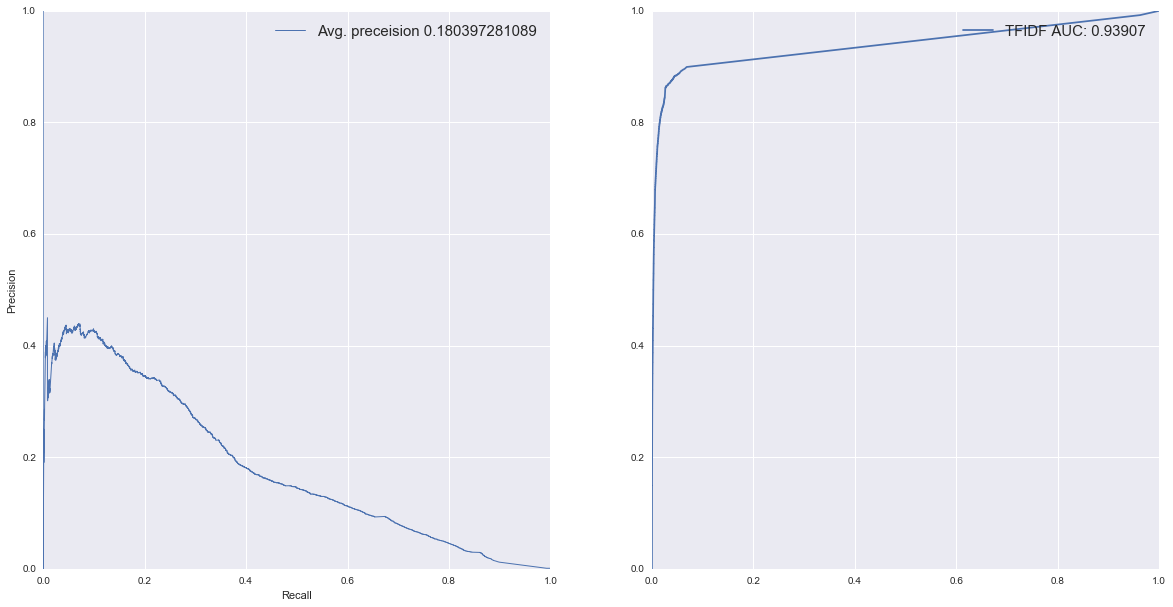

In [164]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(1,2,1)
preds = log.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
ax1.plot(recall, precision, lw=1, label='Avg. preceision {:.4f}'.format(mean_avg_precision))
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend(fontsize=15)
ax2=plt.subplot(1,2,2)
fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label=1)
ax2.plot(fpr, tpr, label="TFIDF AUC: {:.4f}".format(auc(fpr, tpr)))
ax2.legend(fontsize=15)
plt.show()

In [169]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

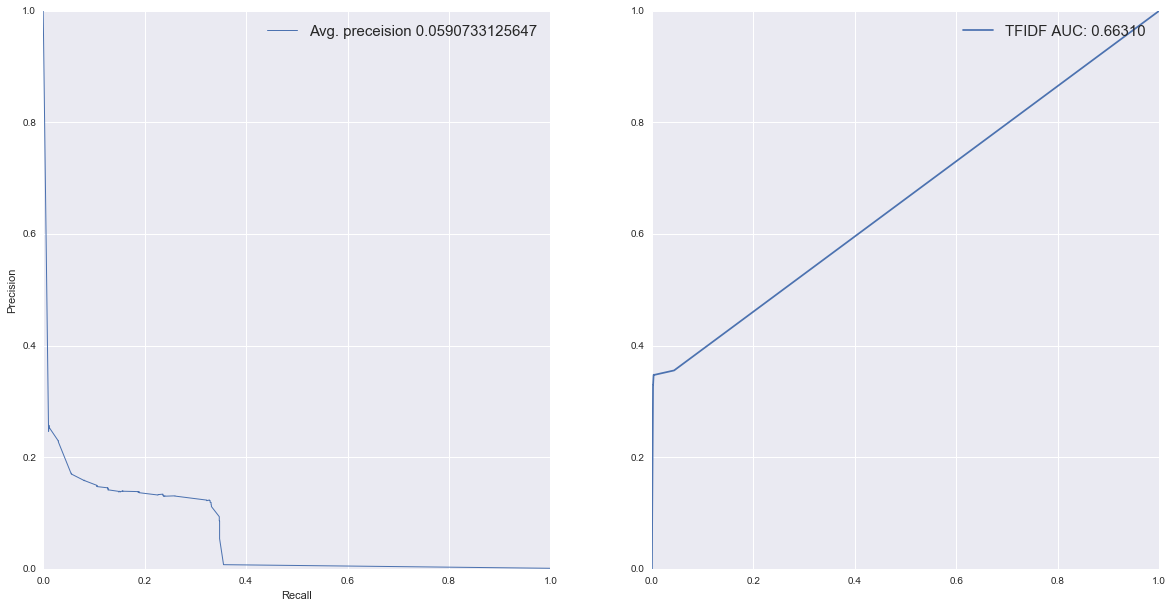

In [170]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(1,2,1)
preds = rf.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
ax1.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend(fontsize=15)
ax2=plt.subplot(1,2,2)
fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label=1)
ax2.plot(fpr, tpr, label="TFIDF AUC: {:.5f}".format(auc(fpr, tpr)))
ax2.legend(fontsize=15)
plt.show()